In [7]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [8]:
class Numbers:
    """
    Class to store MNIST data
    """
    def __init__(self, location):

        import pickle, gzip

        # load data from file 
        f = gzip.open(location, 'rb')
        train_set, valid_set, test_set = pickle.load(f)
        f.close()

        # store for use later  
        self.train_x, self.train_y = train_set
        self.test_x, self.test_y = valid_set

In [9]:
data = Numbers("mnist.pklz")


In [10]:
# Number of examples in the training set
print(len(data.train_x))

# Number of examples in the test set
print(len(data.test_x))

# Number of pixels in each image.
print(data.train_x.shape[-1])

50000
10000
784


In [11]:
class Knearest:
    """
    kNN classifier
    """

    def __init__(self, X, y, k=5):
        """
        Creates a kNN instance

        :param x: Training data input
        :param y: Training data output
        :param k: The number of nearest points to consider in classification
        """

        from sklearn.neighbors import BallTree

        self._kdtree = BallTree(X)
        self._y = y
        self._k = k
        self._counts = self.label_counts()

    def label_counts(self):
        """
        Given the training labels, return a dictionary d where d[y] is
        the number of times that label y appears in the training set.
        """
        dict_label_count = {}
        for i in self._y:
            if i in dict_label_count:
                dict_label_count[i] += 1
            else:
                dict_label_count[i] = 1

        return dict_label_count

    def majority(self, neighbor_indices):
        """
        Given the indices of training examples, return the majority label. Break ties
        by choosing the tied label that appears most often in the training data.

        :param neighbor_indices: The indices of the k nearest neighbors
        """
        assert len(neighbor_indices) == self._k, "Did not get k neighbor indices"

        dict_label_freq = {}

        # Get the label and frequency of each k nearest neighbor

        for i in neighbor_indices:
            if self._y[i] in dict_label_freq:
                dict_label_freq[self._y[i]] = dict_label_freq[self._y[i]] + 1
            else:
                dict_label_freq[self._y[i]] = 1

        # Retrieve the max frequent label
        v = list(dict_label_freq.values())
        max_freq = max(v)
        max_labels = []

        for i in dict_label_freq:
            if dict_label_freq[i] == max_freq:
                max_labels.append(i)

        # In case of tie, return the labels which have more count frequency
        dict_label_count = {}

        if len(max_labels) > 1:
            for i in max_labels:
                dict_label_count[i] = self._counts[i]

            # Retrieve the max count label
            v = list(dict_label_count.values())
            max_count = max(v)
            max_count_label = []

            for i in dict_label_count:
                if dict_label_count[i] == max_count:
                    max_count_label.append(i)

            return max_count_label[0]

        else:
            return max_labels[0]

    def classify(self, example):
        """
        Given an example, return the predicted label.

        :param example: A representation of an example in the same
        format as a row of the training data
        """
        dist, ind = self._kdtree.query([example], self._k)
        neighbors = np.asarray(ind).ravel()
        return self.majority(neighbors)

    def confusion_matrix(self, test_x, test_y):
        """
        Given a matrix of test examples and labels, compute the confusion
        matrix for the current classifier.  Should return a 2-dimensional
        numpy array of ints, C, where C[ii,jj] is the number of times an
        example with true label ii was labeled as jj.

        :param test_x: test data
        :param test_y: true test labels
        """
        C = np.zeros((10, 10), dtype=int)
        for xx, yy in zip(test_x, test_y):
            predicted = self.classify(xx)
            C[yy, predicted] = C[yy, predicted] + 1

        return C

    @staticmethod
    def accuracy(C):
        """
        Given a confusion matrix C, compute the accuracy of the underlying classifier.

        :param C: a confusion matrix
        """

        return np.sum(C.diagonal()) / C.sum()

In [12]:
import unittest

class TestKnn(unittest.TestCase):
    def setUp(self):
        self.x = np.array([[2, 0], [4, 1], [6, 0], [1, 4], [2, 4], [2, 5], [4, 4], [0, 2], [3, 2], [4, 2], [5, 2], [5, 5]])
        self.y = np.array([+1, +1, +1, +1, +1, +1, +1, -1, -1, -1, -1, -1])
        self.knn = {}
        for ii in [1, 2, 3]:
            self.knn[ii] = Knearest(self.x, self.y, ii)

        self.queries = np.array([[1, 5], [0, 3], [6, 4]])
        
    def test0(self):
        """
        Test the label counter 
        """
        self.assertEqual(self.knn[1]._counts[-1], 5)
        self.assertEqual(self.knn[1]._counts[1], 7)

    def test1(self):
        """
        Test 1NN
        """
        self.assertEqual(self.knn[1].classify(self.queries[0]),  1)
        self.assertEqual(self.knn[1].classify(self.queries[1]), -1)
        self.assertEqual(self.knn[1].classify(self.queries[2]), -1)

    def test2(self):
        """
        Test 2NN
        """
        self.assertEqual(self.knn[2].classify(self.queries[0]),  1)
        self.assertEqual(self.knn[2].classify(self.queries[1]),  1)
        self.assertEqual(self.knn[2].classify(self.queries[2]),  1)

    def test3(self):
        """
        Test 3NN
        """
        self.assertEqual(self.knn[3].classify(self.queries[0]),  1)
        self.assertEqual(self.knn[3].classify(self.queries[1]),  1)
        self.assertEqual(self.knn[3].classify(self.queries[2]), -1)
        
tests = TestKnn()
tests_to_run = unittest.TestLoader().loadTestsFromModule(tests)
unittest.TextTestRunner().run(tests_to_run)

....
----------------------------------------------------------------------
Ran 4 tests in 13.425s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

In [75]:
training = data.train_x
test = data.test_x
training_label = data.train_y
test_label = data.test_y

a = [500, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000]
b = []

for i in a:
    train_part = training[0:i, 0:784]
    label_part = training_label[0:i]
    ml_classifier = Knearest(train_part, label_part)
    C_matrix = ml_classifier.confusion_matrix(test[0: int(0.2*i) , 0:784], test_label[0: int(0.2*i)])
    b.append(ml_classifier.accuracy(C_matrix))


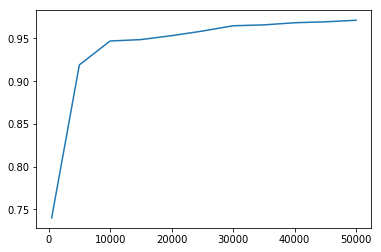

In [76]:
import matplotlib.pyplot as plt
plt.plot(a,b)

In [77]:
train_part = training[0:20000, 0:784]
label_part = training_label[0:20000]

accuracy_k = {}
for i in range(1,20):
    ml_classifier = Knearest(train_part, label_part, i)
    C_matrix = ml_classifier.confusion_matrix(test[0:4000,0:784], test_label[0:4000])
    accuracy_k[i] = ml_classifier.accuracy(C_matrix)
print(accuracy_k)

{1: 0.95499999999999996, 2: 0.93825000000000003, 3: 0.95374999999999999, 4: 0.95025000000000004, 5: 0.95325000000000004, 6: 0.94925000000000004, 7: 0.94999999999999996, 8: 0.94825000000000004, 9: 0.94799999999999995, 10: 0.94499999999999995, 11: 0.94550000000000001, 12: 0.94274999999999998, 13: 0.94350000000000001, 14: 0.94225000000000003, 15: 0.94225000000000003, 16: 0.94099999999999995, 17: 0.94025000000000003, 18: 0.93825000000000003, 19: 0.93799999999999994}


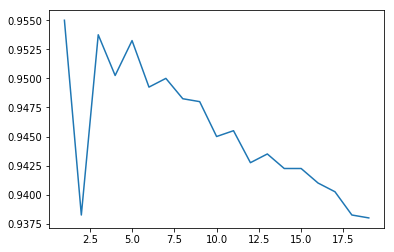

In [78]:
import matplotlib.pyplot as plt
a = list(accuracy_k.keys())
b = list(accuracy_k.values())
plt.plot(a,b)

In [ ]:
def view_digit(example, label=None):
    if label: print("true label: {:d}".format(label))
    plt.imshow(example.reshape(28,28), cmap='gray');

true label: 5


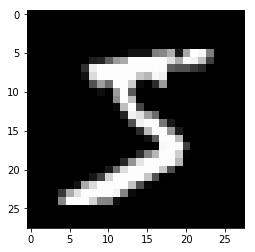

In [58]:
view_digit(data.train_x[0,:], data.train_y[0])

In [135]:
train_part = training[0:20000, 0:784]
label_part = training_label[0:20000]
ml_classifier = Knearest(train_part, label_part, i)
Conf_matrix = ml_classifier.confusion_matrix(test[0:1000], test_label)

In [136]:
print(Conf_matrix)

[[ 98   1   0   0   0   0   1   0   0   0]
 [  0 106   0   0   0   0   0   1   0   0]
 [  0   2  86   1   0   0   0   3   0   1]
 [  0   0   1  98   0   1   0   0   2   3]
 [  0   2   0   0  78   0   0   0   0   9]
 [  0   0   0   1   0  88   0   1   0   1]
 [  1   0   0   0   0   0 103   0   0   0]
 [  0   2   0   0   1   0   0 102   0   1]
 [  0   1   0   4   0   1   0   1  99   1]
 [  2   0   0   1   1   0   0   3   0  91]]


In [140]:
mask = np.ones(C_matrix.shape, dtype=bool)
np.fill_diagonal(mask, 0)
max_value = sorted(Conf_matrix[mask], reverse = True)
print(max_value)
confused_val = {}
row = []
col = []

for i in range(0,6):
    max_val = max_value[i]
    print(max_val)
    k = np.where(Conf_matrix == max_val)
    if len(row) < 6:
        for i in k[0]:
            row.append(i)
        for j in k[1]:
            col.append(j)
    else:
        break
            
for i,j in enumerate(row):
    if j not in confused_val:
        confused_val[j] = col[i]

print(confused_val)    


[9, 4, 3, 3, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
9
4
3
3
3
{8: 3, 9: 7, 2: 7, 3: 9, 4: 9}


In [141]:
train_part = training[0:20000, 0:784]
label_part = training_label[0:20000]
ml_classifier = Knearest(train_part, label_part, i)
confused_example = {}
for index,xx in enumerate(test[0:500]):
    predicted = ml_classifier.classify(xx)
    true_label = test_label[index]
    if len(confused_example) < len(confused_val):
        if true_label in confused_val:
            if confused_val[true_label] == predicted:
                confused_example[true_label,predicted] = index 
    else:
        break    

In [142]:
print(confused_example)

{(2, 7): 229, (3, 9): 431, (4, 9): 5, (9, 7): 462}


true label: 2


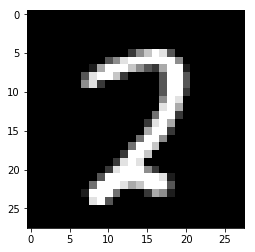

In [143]:
view_digit(data.test_x[229,:], data.test_y[229])

true label: 3


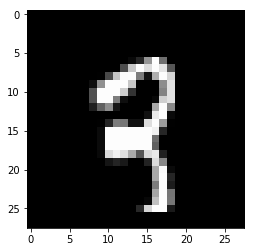

In [144]:
view_digit(data.test_x[431,:], data.test_y[431])

true label: 4


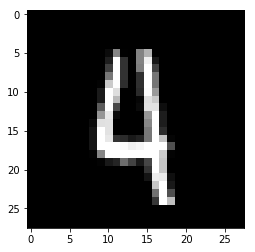

In [145]:
view_digit(data.test_x[5,:], data.test_y[5])

true label: 9


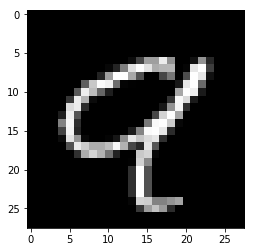

In [146]:
view_digit(data.test_x[462,:], data.test_y[462])